In [495]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pylab as plt
plt.style.use('ggplot')

#Regex
import re

# Stats tools
from scipy import stats

import warnings
warnings.filterwarnings('ignore')


The dataset is available in Kaggle, the description:

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers"

With this quicky description we already can set a few goals:

- Understand the dataset.
- Principal products.
- Principal customers.
- Which country the company export more.
- Which country the company profit more.
- Which product the company needs to focus more by country.
- Sales variation across the time.
- Classify the customers.


# Understand the dataset

In [496]:
# Reading the dataset
df = pd.read_csv('data.csv', encoding= 'unicode_escape')

In [497]:
# Dataset Dimension
print('The dimensions of the data is: ', df.shape)
print('Columns name: ', df.columns)

The dimensions of the data is:  (541909, 8)
Columns name:  Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [498]:
# First entries
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [499]:
pd.DataFrame({'Type':df.dtypes}).value_counts('Type')

Type
object     5
float64    2
int64      1
dtype: int64

In [500]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data Cleaning

One of the first things that we need to do it's to finding the missing values presents in dataset and interpret what's happen.

In [501]:
def missing_values(data):
    total = data.isnull().sum()[data.isnull().sum() !=0]
    percent = round((data.isnull().sum()[data.isnull().sum() !=0])/len(data),3)

    return pd.DataFrame({
        'Total':len(data),
        'Total Missing': total,
        'Percentage':percent
    }).sort_values('Percentage', ascending=False)

In [502]:
missing_values(data = df)

,Total,Total Missing,Percentage
CustomerID,541909,135080,0.249
Description,541909,1454,0.003


CustomerID -> The Id of the customer, it's a unique number assigned to each customer.


Description -> Product name.

We need to study this missing values and understand if is logical reason for this behavior happen.

In [503]:
#Searching the non Cancelled products without the name and CustomerID. 
df.query('CustomerID.isnull()', engine='python')[~df['InvoiceNo'].str.startswith('C') == True]\
    .query('Description.isnull()', engine = 'python')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


So as we can see in the table above, that is some issues in the dataset. The most thing that i notticed it was some rows without the information of the CustomerID.

In [504]:
#Get the index of the results above.
id_remove = df.query('CustomerID.isnull()', engine='python')[~df['InvoiceNo'].str.startswith('C') == True]\
    .query('Description.isnull()', engine = 'python')\
    .index


In [505]:
df_clean = df[~df.index.isin(id_remove)]

In [506]:
missing_values(data = df_clean)

,Total,Total Missing,Percentage
CustomerID,540455,133626,0.247


Checking duplicated rows

In [507]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [508]:
df_clean = df_clean.drop_duplicates()

In [509]:
df_clean.shape

(535187, 8)

In [510]:
id_duplicated = pd.DataFrame({
    'Flag':df_clean.duplicated(subset=['InvoiceNo', 'StockCode', 'Description', 
                                       'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'], keep = False)})\
                .query('Flag == True', engine = 'python')\
                .index

In [511]:
print(len(id_duplicated))

9500


In the code below it's just a example that a purchase duplicated almost columns except from the **Quantity** variable, indicating a 'over' information about the product, so in this cases a good think to do it's join this cases into single one row.

In [512]:
df_clean[df_clean.index.isin(id_duplicated)]\
.query("CustomerID == 12359.0")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
395372,571034,22423,REGENCY CAKESTAND 3 TIER,4,10/13/2011 12:47,12.75,12359.0,Cyprus
395435,571034,22423,REGENCY CAKESTAND 3 TIER,6,10/13/2011 12:47,12.75,12359.0,Cyprus
395456,571034,22423,REGENCY CAKESTAND 3 TIER,3,10/13/2011 12:47,12.75,12359.0,Cyprus


Applying the ideia grouping these informations e making the sum of **Quantity** variable,  we can see in the example below that worked

In [513]:
df_clean[df_clean.index.isin(id_duplicated)]\
.query("CustomerID == 12359.0")\
.groupby(['InvoiceNo', 'StockCode', 'Description', 
          'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'])\
.agg({'Quantity':'sum'}).reset_index()

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Quantity
0,571034,22423,REGENCY CAKESTAND 3 TIER,10/13/2011 12:47,12.75,12359.0,Cyprus,13


Applying for the rest of dataset and saving after.

In [514]:
df_clean2  =  df_clean.groupby(['InvoiceNo', 'StockCode', 'Description', 
                    'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'])\
                    .agg({'Quantity':'sum'})\
                    .reset_index()

In [515]:
print('Change the number of lines')
print('Before: {}'.format(df_clean.shape[0]))
print('After: {}'.format(df_clean2.shape[0]))
print('Difference: {}'.format(df_clean.shape[0] - df_clean2.shape[0]))


Change the number of lines
Before: 535187
After: 396822
Difference: 138365


# Exploratory Data Analysis

In this code below, I just made new features that I considered important for the future results that I will demonstrate.

In [516]:
df_final = df_clean2
# Creating variables related to time.
df_final["Date"]= pd.to_datetime(df['InvoiceDate'])
df_final['Date2'] = df_final['Date'].apply(lambda x: x.date())
df_final["Day"] = df_final['Date'].apply(lambda x: x.day)
df_final["Month"] = df_final['Date'].apply(lambda x: x.month)
df_final["Year"] = df_final['Date'].apply(lambda x: x.year)
df_final["Week"] = df_final['Date'].apply(lambda x: x.week)
df_final["Hour"] = df_final['Date'].apply(lambda x: x.hour)

# Creating others variables
df_final['TotalPrice'] = df_final['Quantity'] * df_final['UnitPrice']
df_final['Cancelled'] = df_final['InvoiceNo'].apply(lambda x: 'Yes' if re.search('^C', x) else 'No')
df_final['CustomerID_V2'] = df_final['CustomerID'].fillna('Unspecified')

Overview Results:

In [517]:
df_final[['UnitPrice', 'Quantity', 'TotalPrice']].describe()

,UnitPrice,Quantity,TotalPrice
count,396822.000000,396822.000000,396822.000000
mean,3.492854,12.330090,20.862048
std,70.182666,251.787908,432.939244
min,0.000000,-80995.000000,-168469.600000
25%,1.250000,2.000000,4.680000
50%,1.950000,6.000000,11.900000
75%,3.750000,12.000000,19.800000
max,38970.000000,80995.000000,168469.600000


In [518]:
df_final.head(2)

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Quantity,Date,Date2,Day,Month,Year,Week,Hour,TotalPrice,Cancelled,CustomerID_V2
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,12/1/2010 8:26,4.25,17850.0,United Kingdom,6,2010-12-01 08:26:00,2010-12-01,1,12,2010,48,8,25.5,No,17850.0
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,12/1/2010 8:26,7.65,17850.0,United Kingdom,2,2010-12-01 08:26:00,2010-12-01,1,12,2010,48,8,15.3,No,17850.0


The first thing with we want only observe the non-cancelled Sales and having some insight's about the data, for this we need to keep only the products that weren't had an cancelled operation, like the example below:

In [519]:
df_final.query("StockCode == '23843'")

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Quantity,Date,Date2,Day,Month,Year,Week,Hour,TotalPrice,Cancelled,CustomerID_V2
387523,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",12/9/2011 9:15,2.08,16446.0,United Kingdom,80995,2011-10-10 12:00:00,2011-10-10,10,10,2011,41,12,168469.6,No,16446.0
396815,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",12/9/2011 9:27,2.08,16446.0,United Kingdom,-80995,2011-10-13 15:47:00,2011-10-13,13,10,2011,41,15,-168469.6,Yes,16446.0


As we can see in the day of **12/9/2011 at 9:15** the Customer **16446.0** bought 80995 quantity's of one product, totalizing **USD 168469.6**, but after few minutes the customer cancelled the operation. 

For this cases we need to filtering and only keep the Sales that weren't cancelled.

In [520]:
df_final_onlySales = df_final.groupby(['StockCode','Description', 'UnitPrice', 'CustomerID', 'Country'])\
                    .agg({'Quantity':'sum',
                        'TotalPrice':'sum'})\
                    .reset_index()\
                    .query("TotalPrice != 0 and Quantity > 0", engine = 'python')

- The most expensive product sold was:

In [521]:
df_final_onlySales[df_final_onlySales['UnitPrice'] == df_final_onlySales['UnitPrice'].max()]

,StockCode,Description,UnitPrice,CustomerID,Country,Quantity,TotalPrice
276976,M,Manual,2500.0,15581.0,United Kingdom,1,2500.0


- And the cheapest products sold were:

In [522]:
df_final_onlySales[df_final_onlySales['UnitPrice'] == df_final_onlySales['UnitPrice'].min()]

,StockCode,Description,UnitPrice,CustomerID,Country,Quantity,TotalPrice
276451,BANK CHARGES,Bank Charges,0.001,13405.0,United Kingdom,1,0.001
276985,PADS,PADS TO MATCH ALL CUSHIONS,0.001,13952.0,United Kingdom,1,0.001
276986,PADS,PADS TO MATCH ALL CUSHIONS,0.001,15618.0,United Kingdom,1,0.001
276987,PADS,PADS TO MATCH ALL CUSHIONS,0.001,16198.0,United Kingdom,1,0.001


- The top 10 products with more profit.

In [523]:
df_final_onlySales.groupby('Description')['TotalPrice']\
            .sum()\
            .sort_values(ascending=False)\
            .head(10)


Description
REGENCY CAKESTAND 3 TIER              132897.85
WHITE HANGING HEART T-LIGHT HOLDER     93775.85
JUMBO BAG RED RETROSPOT                83259.90
POSTAGE                                68389.21
PARTY BUNTING                          67708.18
ASSORTED COLOUR BIRD ORNAMENT          56345.43
RABBIT NIGHT LIGHT                     51065.72
CHILLI LIGHTS                          45915.41
PAPER CHAIN KIT 50'S CHRISTMAS         41543.48
PICNIC BASKET WICKER 60 PIECES         39619.50
Name: TotalPrice, dtype: float64

In [524]:
df_most_profit = pd.DataFrame({'Profit':df_final_onlySales.groupby('Description')['TotalPrice'].sum()})\
                .reset_index()\
                .sort_values('Profit', ascending=False)

df_most_profit['Percent'] = round((df_most_profit['Profit']/df_most_profit['Profit'].sum())*100,4)
df_most_profit['Percent'].head(10).sum().round(2)


8.11

These list of products above represents only **8.11%** of the all profit.

- Top 10 most common products sold:

In [477]:
df_final_onlySales.value_counts('Description')\
            .sort_values(ascending=False)\
            .head(10)

Description
REGENCY CAKESTAND 3 TIER              910
WHITE HANGING HEART T-LIGHT HOLDER    900
JUMBO BAG RED RETROSPOT               830
PARTY BUNTING                         766
ASSORTED COLOUR BIRD ORNAMENT         692
SET OF 3 CAKE TINS PANTRY DESIGN      649
PACK OF 72 RETROSPOT CAKE CASES       638
PAPER CHAIN KIT 50'S CHRISTMAS        630
JAM MAKING SET WITH JARS              596
NATURAL SLATE HEART CHALKBOARD        595
dtype: int64

In [525]:
df_most_commom = pd.DataFrame({'Count':df_final_onlySales.value_counts('Description')})\
                .reset_index()\
                .sort_values('Count', ascending=False)

df_most_commom['Percent'] = ((df_most_commom['Count']/df_most_commom['Count'].sum())*100)
df_most_commom['Percent'].head(10).sum().round(2)

2.63

These list of products above represents only **2.63%** of the all rest.

- The top 10 products with more quantity bought.

In [479]:
df_final_onlySales.groupby('Description')['Quantity']\
            .sum()\
            .sort_values(ascending=False)\
            .head(10)

Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53311
JUMBO BAG RED RETROSPOT               45178
ASSORTED COLOUR BIRD ORNAMENT         35322
WHITE HANGING HEART T-LIGHT HOLDER    34150
PACK OF 72 RETROSPOT CAKE CASES       33502
POPCORN HOLDER                        30629
RABBIT NIGHT LIGHT                    27105
MINI PAINT SET VINTAGE                25880
PACK OF 12 LONDON TISSUES             25321
PACK OF 60 PINK PAISLEY CAKE CASES    24167
Name: Quantity, dtype: int64

After this, we can now on doing some specific observations, one of those is observe the data by costumer, country and time. 

In this results we don't want care about products who only got sailed, but also in those products whose got cancelled.

## Analysis by Customers.

In [480]:
df_top_customers = df_final.groupby('CustomerID_V2')\
            .agg({'Quantity': 'sum',
                  'UnitPrice': 'sum',
                  'TotalPrice': 'sum'})\
            .sort_values('TotalPrice', ascending = False)\
            .reset_index()

df_top_customers.head(10)

,CustomerID_V2,Quantity,UnitPrice,TotalPrice
0,14646.0,196719,5400.21,279489.02
1,18102.0,64122,5159.73,256438.49
2,17450.0,69029,3312.09,187482.17
3,14911.0,77180,31025.29,132572.62
4,12415.0,77242,2499.82,123725.45
5,14156.0,57025,6534.09,113384.14
6,17511.0,63012,2607.08,88125.38
7,16684.0,49390,709.93,65892.08
8,13694.0,61803,1163.42,62653.10
9,15311.0,37720,6232.32,59419.34


Another thing that we can observe it's the difference between the Number of transactions and Number of cancelled transactions. In one transaction the customer can do more than one buy.

In [481]:
num_transactions_by_customer = df_final.groupby('CustomerID_V2')['InvoiceNo'].nunique()
num_cancelled_transactions_by_customer = df_final.query("Cancelled == 'Yes'").groupby('CustomerID_V2')['InvoiceNo'].nunique()

df_unique_transactions_by_customer = pd.merge(num_transactions_by_customer, num_cancelled_transactions_by_customer, how = 'left', on='CustomerID_V2')\
        .rename(columns={'InvoiceNo_x': 'NumTotalTransactions', 'InvoiceNo_y': 'NumCancelled_Transactions'})\
        .sort_values('NumTotalTransactions', ascending=False)\
        .reset_index()

df_unique_transactions_by_customer['NumTransactions'] = df_unique_transactions_by_customer['NumTotalTransactions'] - df_unique_transactions_by_customer['NumCancelled_Transactions']

df_unique_transactions_by_customer.head(10)    


,CustomerID_V2,NumTotalTransactions,NumCancelled_Transactions,NumTransactions
0,14911.0,248,47.0,201.0
1,12748.0,224,14.0,210.0
2,17841.0,169,45.0,124.0
3,14606.0,128,35.0,93.0
4,13089.0,118,21.0,97.0
5,15311.0,118,27.0,91.0
6,12971.0,89,3.0,86.0
7,14527.0,86,31.0,55.0
8,13408.0,81,19.0,62.0
9,14646.0,77,3.0,74.0


In [482]:
df_unique_transactions_by_customer_melt = pd.melt(df_unique_transactions_by_customer, 
                                                id_vars = 'CustomerID_V2', 
                                                var_name = 'Type',
                                                value_name = 'Num',
                                                value_vars=['NumCancelled_Transactions', 'NumTransactions'])
                                            

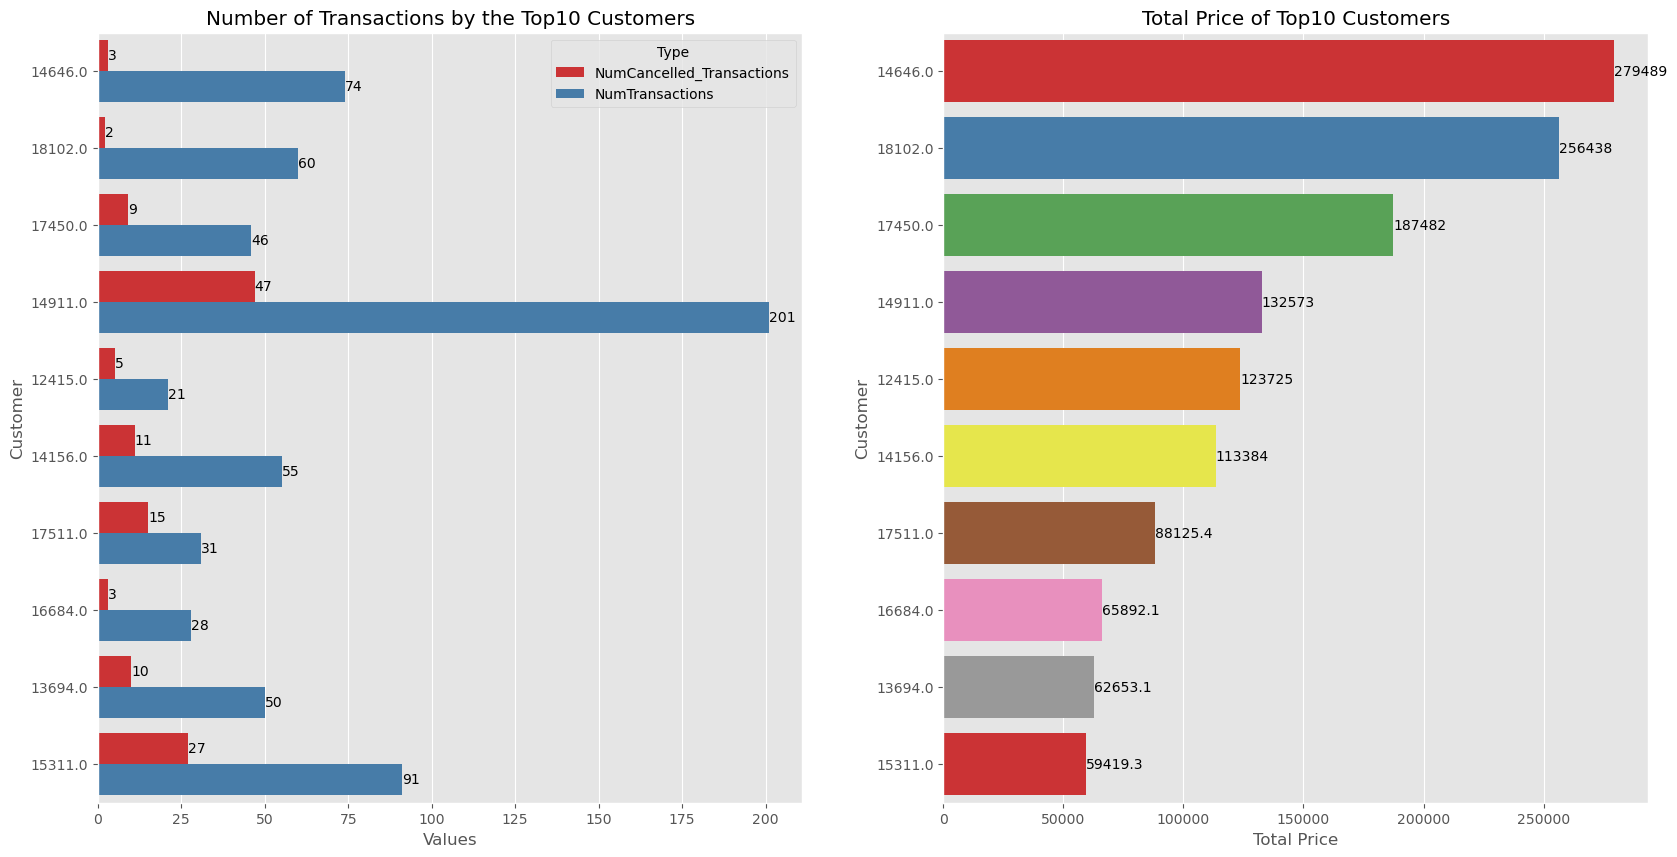

In [483]:
# Crossing the informations
fig = plt.figure(constrained_layout = True, figsize = (20,10))
grid = plt.GridSpec(ncols = 2, nrows = 1)

ax1 = fig.add_subplot(grid[0,0])
sns.barplot(x = 'Num', y = 'CustomerID_V2', palette = 'Set1', hue = 'Type',
            data = df_unique_transactions_by_customer_melt,
            orient='h',
            order = df_top_customers['CustomerID_V2'].head(10))
ax1.set_title('Number of Transactions by the Top10 Customers')
ax1.set_ylabel('Customer')
ax1.set_xlabel('Values')
ax1.bar_label(ax1.containers[0])
ax1.bar_label(ax1.containers[1])


ax2 = fig.add_subplot(grid[0,1])
ax2 = sns.barplot(x = 'TotalPrice', y = 'CustomerID_V2', palette = 'Set1',
            data = df_top_customers[['CustomerID_V2','TotalPrice']].head(10), 
            orient='h',
            order = df_top_customers['CustomerID_V2'].head(10))
ax2.set_title('Total Price of Top10 Customers')
ax2.set_ylabel('Customer')
ax2.set_xlabel('Total Price')
ax2.bar_label(ax2.containers[0])
plt.show()


With this information we can create another feature that represents the Amount price by the Total Transactions, this represents the customer's that spent more money in an minimum number os transactions.

In [484]:
df_crossing = df_top_customers.merge(df_unique_transactions_by_customer, how='left', on='CustomerID_V2')
df_crossing['TotalPrice_per_Transactions'] = df_crossing['TotalPrice']/df_crossing['NumTotalTransactions']

df_crossing[['CustomerID_V2', 'TotalPrice', 'NumTotalTransactions','TotalPrice_per_Transactions']]\
    .sort_values('TotalPrice_per_Transactions', ascending=False)\
    .head(10)

,CustomerID_V2,TotalPrice,NumTotalTransactions,TotalPrice_per_Transactions
191,12357.0,6207.67,1,6207.670000
34,15749.0,21535.90,4,5383.975000
271,12688.0,4873.81,1,4873.810000
4,12415.0,123725.45,26,4758.671154
313,12752.0,4366.78,1,4366.780000
317,18251.0,4314.72,1,4314.720000
1,18102.0,256438.49,62,4136.104677
69,16000.0,12393.70,3,4131.233333
350,12378.0,4008.62,1,4008.620000
132,12435.0,7829.89,2,3914.945000


In [485]:
df_description_customer = pd.DataFrame(df_final.groupby(['Description', 'CustomerID_V2'])['TotalPrice'].sum())\
                        .reset_index()\
                        .sort_values('TotalPrice', ascending = False)
                    
df_description_customer.head(10)

,Description,CustomerID_V2,TotalPrice
161095,PICNIC BASKET WICKER 60 PIECES,15098.0,39619.50
252199,VINTAGE UNION JACK MEMOBOARD,18102.0,16592.08
24113,BLACK RECORD COVER FRAME,16210.0,16027.92
258765,WOOD BLACK BOARD ANT WHITE FINISH,18102.0,15351.00
54081,CREAM HEART CARD HOLDER,18102.0,14089.90
186491,REGENCY CAKESTAND 3 TIER,15061.0,14081.70
98527,HEART OF WICKER LARGE,17450.0,13427.64
255689,WHITE HANGING HEART T-LIGHT HOLDER,17450.0,13253.84
64070,DOTCOM POSTAGE,14096.0,11906.36
218208,SET OF TEA COFFEE SUGAR TINS PANTRY,17450.0,10566.73


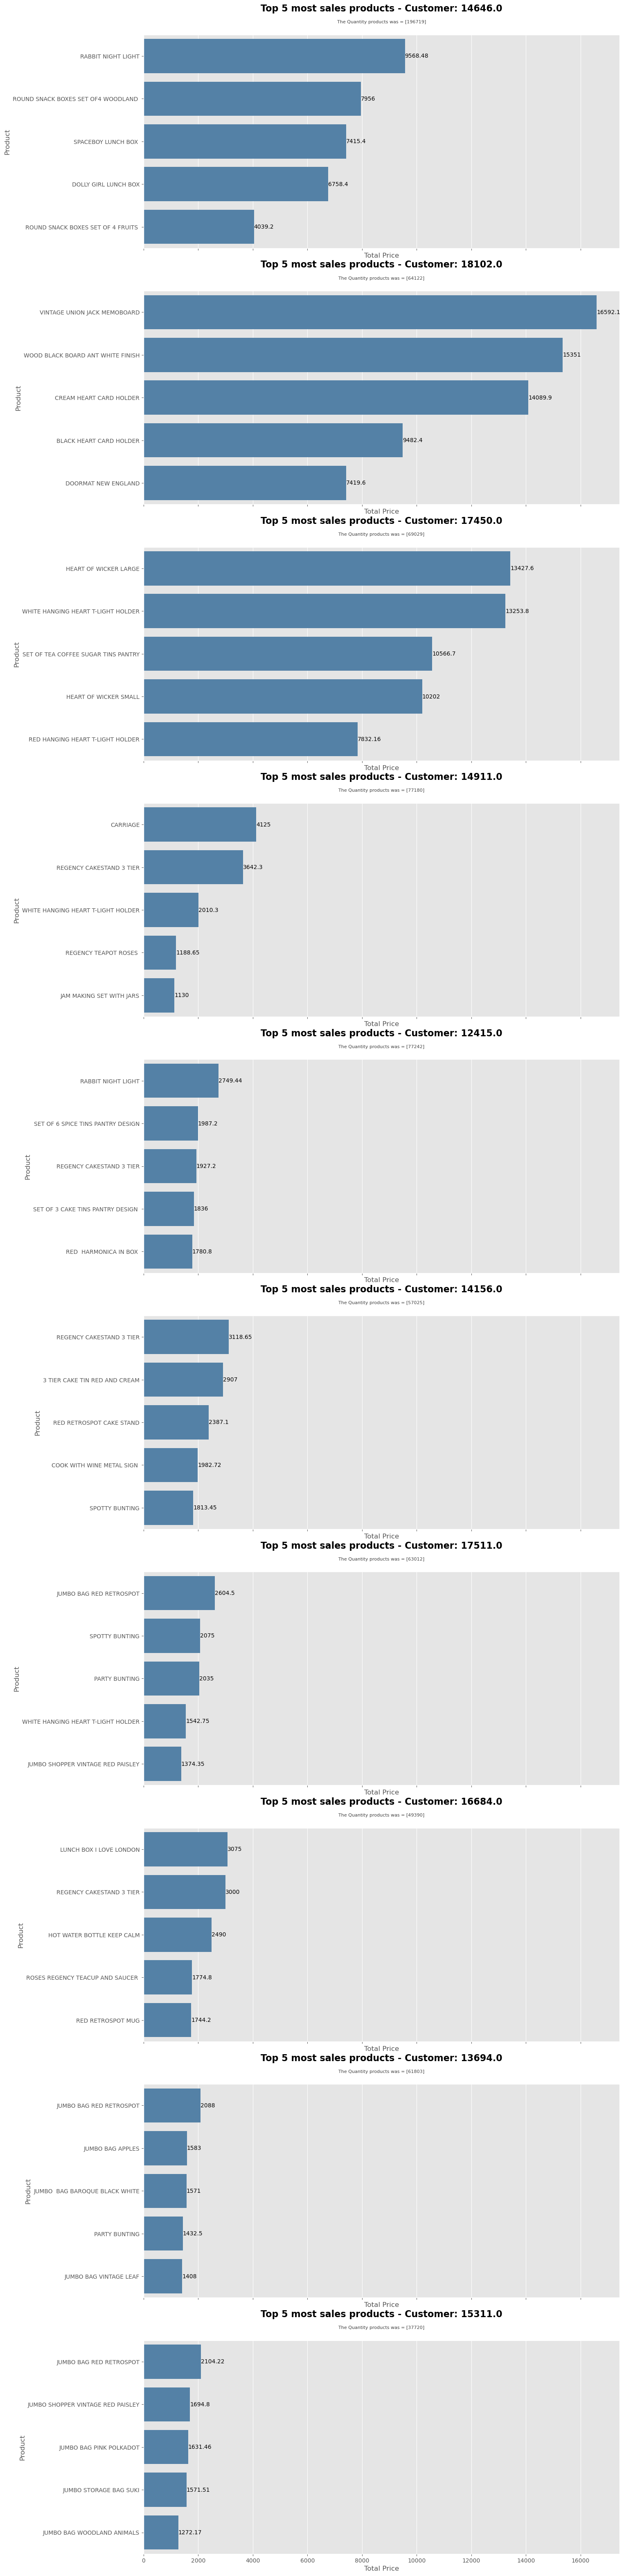

In [486]:
customers = df_top_customers['CustomerID_V2'].head(10).unique()
figure, axes = plt.subplots(10, 1, sharex=True, figsize=(15, 80))
for i in range(0, len(customers)):
    data = df_description_customer[df_description_customer['CustomerID_V2'] == customers[i]].head(5)
    sns.barplot(x = 'TotalPrice', y = 'Description', color = 'steelblue',
                data = data, order = data['Description'], ax = axes[i])
    axes[i].text(x=0.5, y=1.1, s= 'Top 5 most sales products - Customer: {}'.format(customers[i]),
     fontsize=16, weight='bold', ha='center', va='bottom', transform=axes[i].transAxes)
    axes[i].text(x=0.5, y=1.05, s='The Quantity products was = {}'.format(str(df_top_customers[df_top_customers['CustomerID_V2'] == customers[i]]['Quantity'].values)),
     fontsize=8, alpha=0.75, ha='center', va='bottom', transform=axes[i].transAxes)            
    axes[i].set_ylabel('Product')
    axes[i].set_xlabel('Total Price')
    axes[i].bar_label(axes[i].containers[0])

## Analysis by Country.

In [487]:
df_top_country = df_final\
            .groupby('Country')\
            .agg({'Quantity': 'sum',
                  'UnitPrice': 'sum',
                  'TotalPrice': 'sum'})\
            .sort_values('TotalPrice', ascending = False)\
            .reset_index()

df_top_country.head(10)

,Country,Quantity,UnitPrice,TotalPrice
0,United Kingdom,4008533,1156868.114,6767873.394
1,Netherlands,200128,6492.550,284661.540
2,EIRE,136329,38208.010,250285.220
3,Germany,117448,37618.490,221698.210
4,France,109848,42796.640,196712.840
5,Australia,83653,4043.850,137077.270
6,Switzerland,29778,6568.600,55739.400
7,Spain,26824,12593.720,54774.580
8,Belgium,23152,7540.130,40910.960
9,Sweden,35637,1804.730,36595.910


In [488]:
num_transactions_by_country = df_final.groupby('Country')['InvoiceNo'].nunique()
num_cancelled_transactions_by_country = df_final.query("Cancelled == 'Yes'").groupby('Country')['InvoiceNo'].nunique()

df_unique_transactions_by_country = pd.merge(num_transactions_by_country, num_cancelled_transactions_by_country, how = 'left' ,on='Country')\
        .rename(columns={'InvoiceNo_x': 'NumTotalTransactions', 
                         'InvoiceNo_y': 'NumCancelled_Transactions'})\
        .sort_values('NumTotalTransactions', ascending=False)\
        .reset_index()

df_unique_transactions_by_country['NumTransactions'] = df_unique_transactions_by_country['NumTotalTransactions'] - df_unique_transactions_by_country['NumCancelled_Transactions']

df_unique_transactions_by_country.head(10)

,Country,NumTotalTransactions,NumCancelled_Transactions,NumTransactions
0,United Kingdom,19857,3208.0,16649.0
1,Germany,603,146.0,457.0
2,France,458,69.0,389.0
3,EIRE,319,59.0,260.0
4,Belgium,119,21.0,98.0
5,Spain,105,15.0,90.0
6,Netherlands,101,6.0,95.0
7,Switzerland,71,20.0,51.0
8,Portugal,70,13.0,57.0
9,Australia,69,12.0,57.0


In [489]:
df_unique_transactions_by_country_melt = pd.melt(df_unique_transactions_by_country, 
                                                id_vars = 'Country', 
                                                var_name = 'Type',
                                                value_name = 'Num',
                                                value_vars=['NumTransactions', 'NumCancelled_Transactions'])

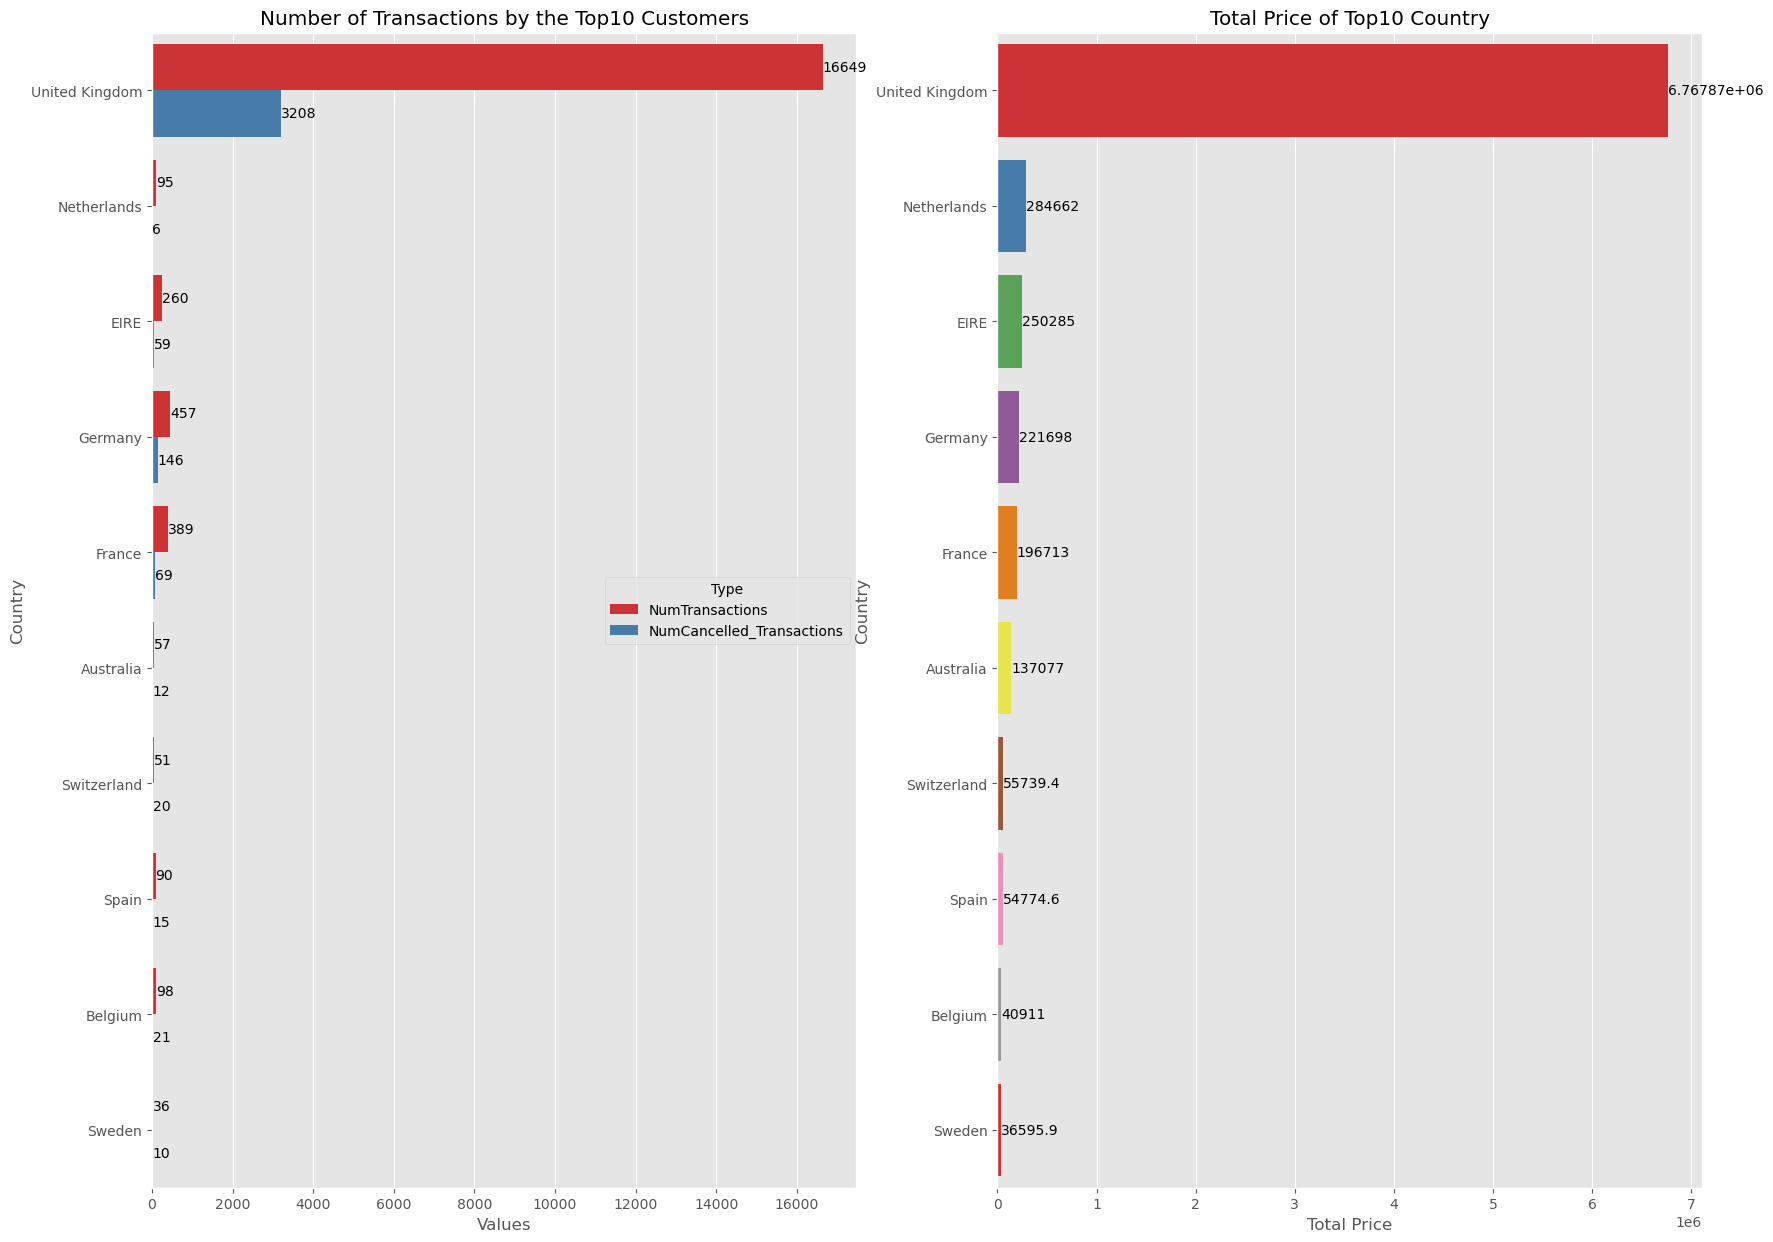

In [490]:
# Crossing the informations
fig = plt.figure(constrained_layout = True, figsize = (20,15))
grid = plt.GridSpec(ncols = 2, nrows = 1)

ax1 = fig.add_subplot(grid[0,0])
sns.barplot(x = 'Num', y = 'Country', palette = 'Set1', hue = 'Type',
            data = df_unique_transactions_by_country_melt,
            orient='h',
            order = df_top_country['Country'].head(10))
ax1.set_title('Number of Transactions by the Top10 Customers')
ax1.set_ylabel('Country')
ax1.set_xlabel('Values')
ax1.bar_label(ax1.containers[0])
ax1.bar_label(ax1.containers[1])
ax1.legend(loc='center right', title='Type')


ax2 = fig.add_subplot(grid[0,1])
ax2 = sns.barplot(x = 'TotalPrice', y = 'Country', palette = 'Set1',
            data = df_top_country[['Country','TotalPrice']].head(10), 
            orient='h',
            order = df_top_country['Country'].head(10))
ax2.set_title('Total Price of Top10 Country')
ax2.set_ylabel('Country')
ax2.set_xlabel('Total Price')
ax2.bar_label(ax2.containers[0])
plt.show()

In [491]:
df_crossing = df_top_country.merge(df_unique_transactions_by_country, how='left', on='Country')
df_crossing['TotalPrice_per_Transactions'] = df_crossing['TotalPrice']/df_crossing['NumTotalTransactions']

df_crossing = df_crossing[['Country', 'TotalPrice', 'NumTotalTransactions','TotalPrice_per_Transactions']]\
    .sort_values('TotalPrice_per_Transactions', ascending=False)

df_crossing

,Country,TotalPrice,NumTotalTransactions,TotalPrice_per_Transactions
1,Netherlands,284661.540,101,2818.431089
5,Australia,137077.270,69,1986.627101
29,Lebanon,1693.880,1,1693.880000
10,Japan,35340.620,28,1262.165000
21,Israel,6994.250,6,1165.708333
32,Brazil,1143.600,1,1143.600000
33,RSA,1002.310,1,1002.310000
19,Singapore,9120.390,10,912.039000
15,Denmark,18768.140,21,893.720952
11,Norway,35163.460,40,879.086500


In [492]:
df_description_country = pd.DataFrame(df_final.groupby(['Description', 'Country'])['TotalPrice'].sum())\
                        .reset_index()\
                        .sort_values('TotalPrice', ascending = False)
                    
df_description_country.head(10)

,Description,Country,TotalPrice
13478,REGENCY CAKESTAND 3 TIER,United Kingdom,103122.85
18450,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,88313.95
8292,JUMBO BAG RED RETROSPOT,United Kingdom,75416.67
11224,PARTY BUNTING,United Kingdom,61952.58
1104,ASSORTED COLOUR BIRD ORNAMENT,United Kingdom,52314.87
3542,CHILLI LIGHTS,United Kingdom,45155.61
11480,PICNIC BASKET WICKER 60 PIECES,United Kingdom,39619.50
11068,PAPER CHAIN KIT 50'S CHRISTMAS,United Kingdom,39596.73
1763,BLACK RECORD COVER FRAME,United Kingdom,37799.42
18628,WOOD BLACK BOARD ANT WHITE FINISH,United Kingdom,33408.76


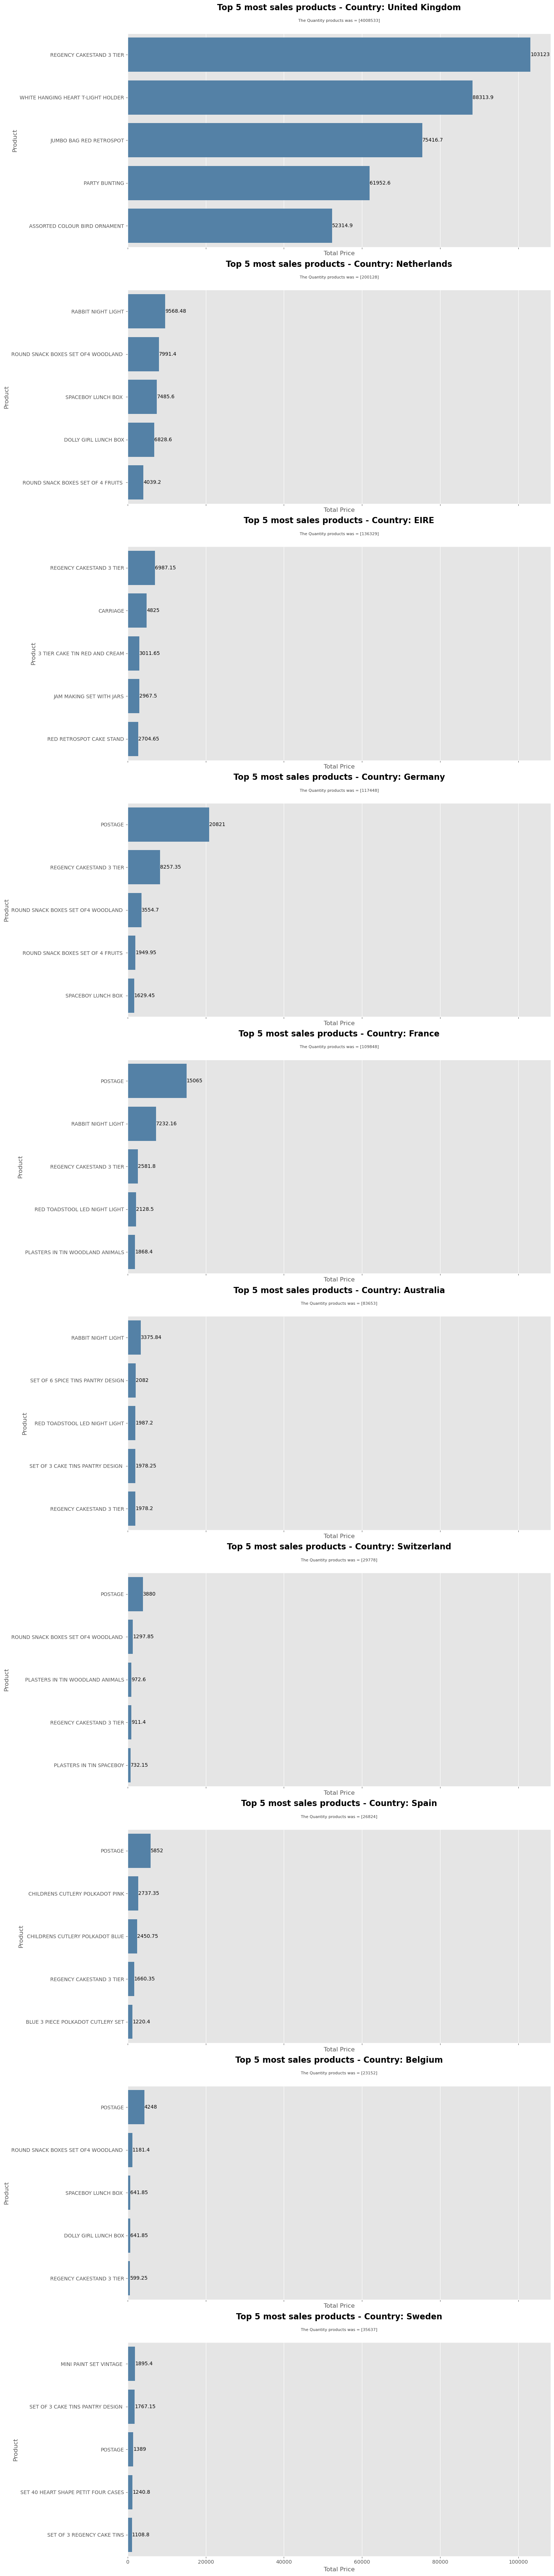

In [493]:
countrys = df_top_country['Country'].head(10).unique()
figure, axes = plt.subplots(10, 1, sharex=True, figsize=(15, 90))
for i in range(0, len(countrys)):
    data = df_description_country[df_description_country['Country'] == countrys[i]].head(5)
    sns.barplot(x = 'TotalPrice', y = 'Description', color = 'steelblue',
                data = data, 
                order = data['Description'], ax = axes[i])
    axes[i].text(x=0.5, y=1.1, s= 'Top 5 most sales products - Country: {}'.format(countrys[i]),
     fontsize=16, weight='bold', ha='center', va='bottom', transform=axes[i].transAxes)
    axes[i].text(x=0.5, y=1.05, s='The Quantity products was = {}'.format(str(df_top_country[df_top_country['Country'] == countrys[i]]['Quantity'].values)),
     fontsize=8, alpha=0.75, ha='center', va='bottom', transform=axes[i].transAxes)    
    axes[i].set_ylabel('Product')
    axes[i].set_xlabel('Total Price')
    axes[i].bar_label(axes[i].containers[0])
    

## Analysis by Time

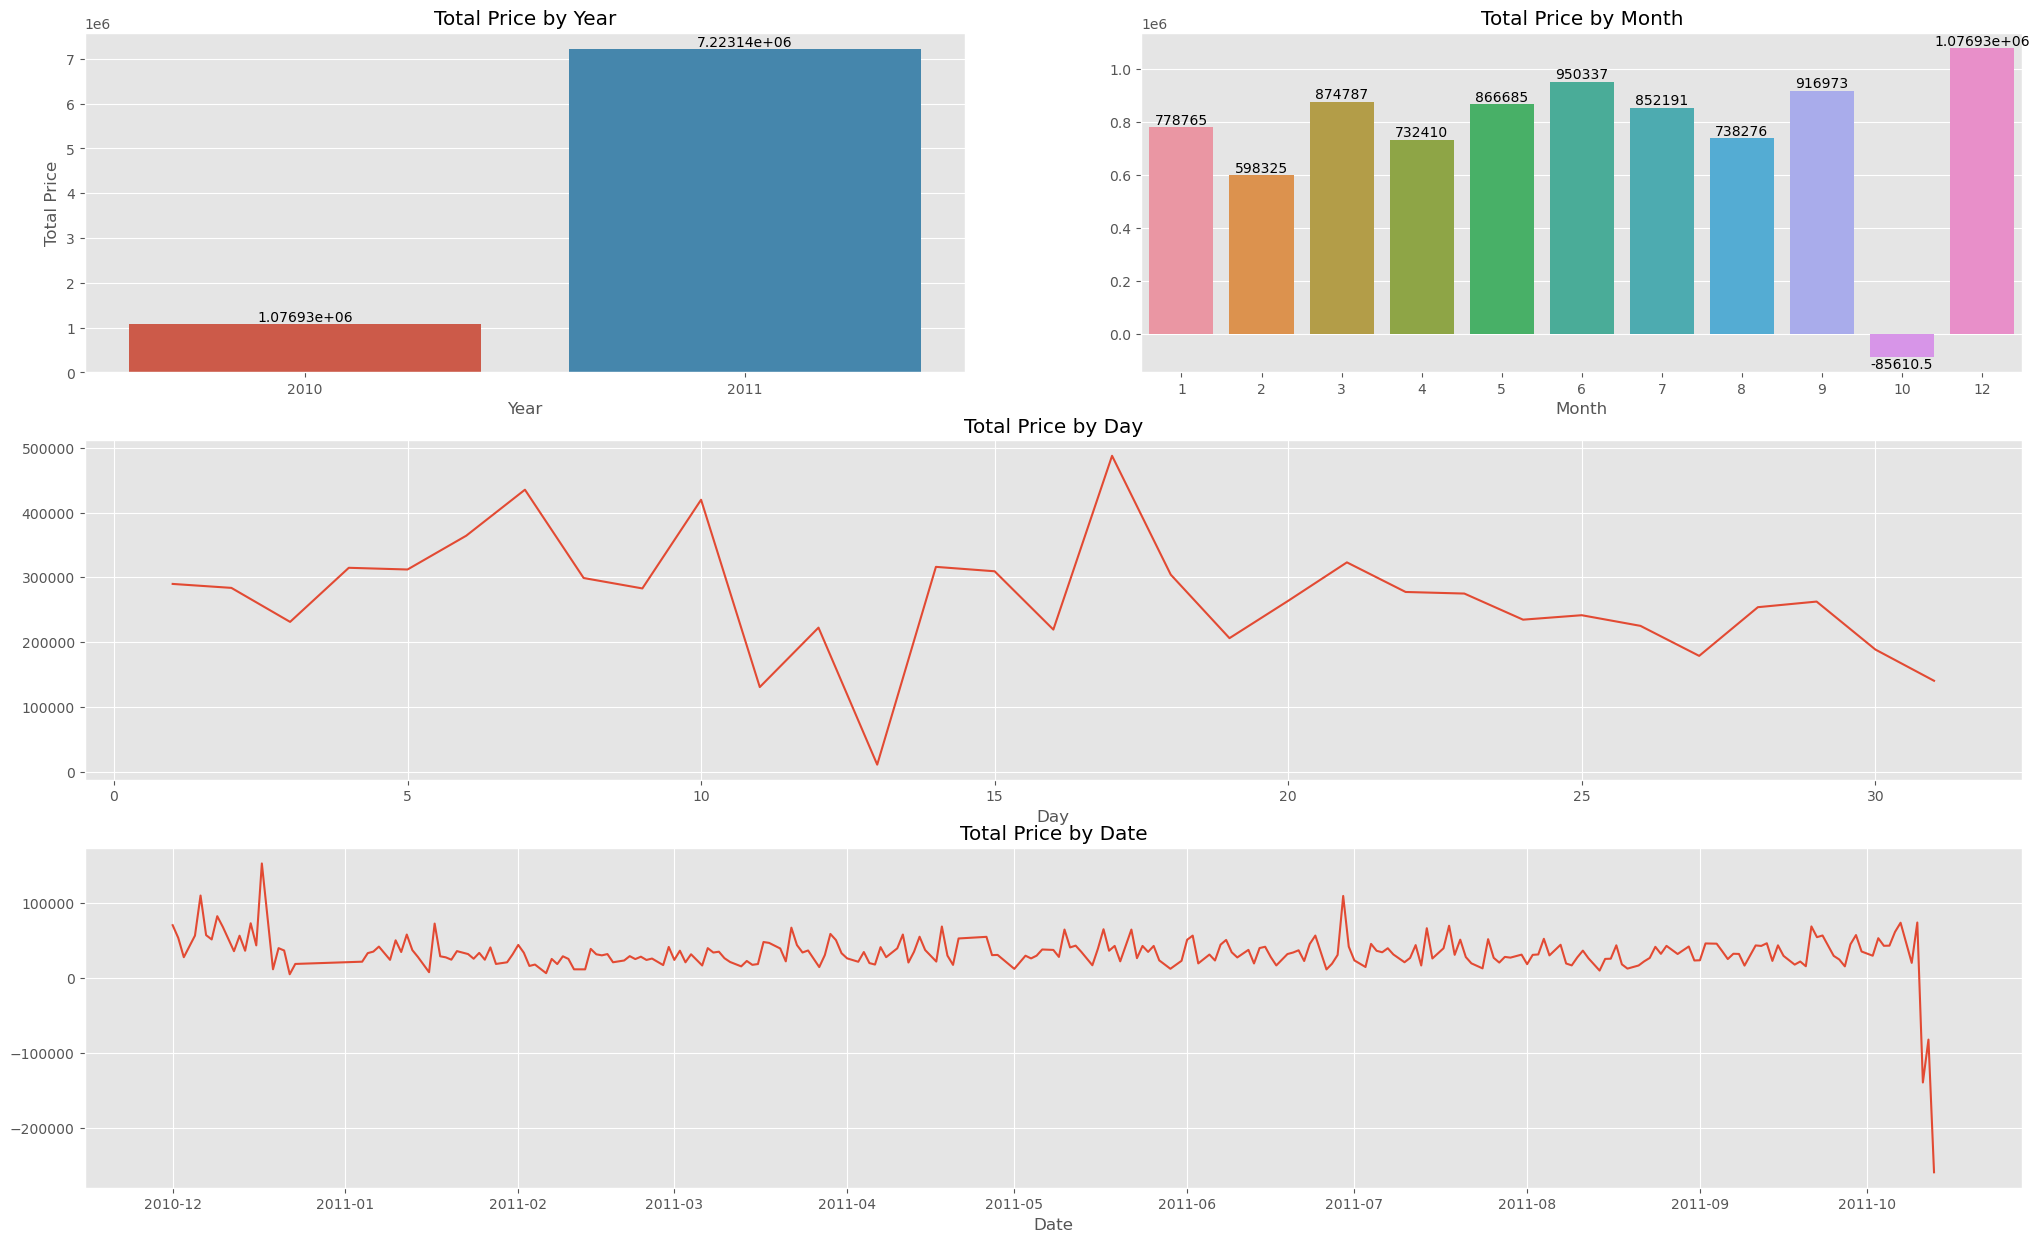

In [494]:
total_sales_by_year = df_final.groupby('Year')['TotalPrice'].sum()
total_sales_by_month = df_final.groupby('Month')['TotalPrice'].sum()
total_sales_by_day = df_final.groupby('Day')['TotalPrice'].sum()
total_sales_by_date = df_final.groupby('Date2')['TotalPrice'].sum()

fig = plt.figure(constrained_layout = True, figsize = (25,15))
grid = plt.GridSpec(ncols = 2, nrows = 3)

ax1 = fig.add_subplot(grid[0,0])
sns.barplot(x = total_sales_by_year.index, y = total_sales_by_year.values)
ax1.set_title('Total Price by Year')
ax1.set_ylabel('Total Price')
ax1.set_xlabel('Year')
ax1.bar_label(ax1.containers[0])

ax2 = fig.add_subplot(grid[0,1])
sns.barplot(x = total_sales_by_month.index, y = total_sales_by_month.values)
ax2.set_title('Total Price by Month')
ax2.set_xlabel('Month')
ax2.bar_label(ax2.containers[0])

ax3 = fig.add_subplot(grid[1,0:2])
sns.lineplot(x=total_sales_by_day.index, y=total_sales_by_day.values, ax=ax3)
ax3.set_title('Total Price by Day')
ax3.set_xlabel('Day')

ax4 = fig.add_subplot(grid[2,0:2])
sns.lineplot(x=total_sales_by_date.index, y=total_sales_by_date.values, ax=ax4)
ax4.set_title('Total Price by Date')
ax4.set_xlabel('Date')
plt.show()


# Groupement Analysis

In this next topic the objective it's to understand the customer and try to group them in clusters, this is can be very helpful because we can create more than one profile base on of their characteristics. As we stand with only numeric variable the **K-means** algorithm can be usefull.

In [536]:
df_customer = df_final[["CustomerID_V2", "InvoiceNo", "UnitPrice", "Quantity", "TotalPrice"]]\
        .groupby('CustomerID_V2')\
        .agg({"UnitPrice":'sum',
            "InvoiceNo":'count',
            "Quantity":'sum',
            "TotalPrice":'sum'})\
        .reset_index().query("Quantity != 0")

In [556]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_customer['CustomerID_V2'] = label_encoder.fit_transform(df_customer['CustomerID_V2'])

In [568]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_customer)

clusters = kmeans.predict(df_customer)

df_customer['Cluster'] = clusters

In [569]:
df_customer.head(5)

,CustomerID_V2,UnitPrice,InvoiceNo,Quantity,TotalPrice,Cluster
1,0,481.21,182,2458,4310.00,0
2,1,178.71,31,2341,1797.24,0
3,2,605.10,73,631,1757.55,0
4,3,65.30,17,197,334.40,0
5,4,2211.10,95,470,1545.41,0


In [584]:
df_cluster = pd.DataFrame({'Count':df_customer.value_counts('Cluster')}).reset_index().sort_values('Cluster')
df_cluster['Percent'] = round(df_cluster['Count']/df_cluster['Count'].sum(), 3)*100

df_customer2 = df_customer.groupby('Cluster')\
                .agg({
                    "UnitPrice": "mean",
                    "InvoiceNo": "mean",
                    "Quantity": "mean",
                    "TotalPrice": "mean"  
                }).reset_index()

pd.merge(df_cluster, df_customer2, how = 'left')

,Cluster,Count,Percent,UnitPrice,InvoiceNo,Quantity,TotalPrice
0,0,4334,99.4,278.041581,82.568989,856.993078,1442.639761
1,1,3,0.1,4624.010000,956.000000,109950.000000,241083.226667
2,2,22,0.5,7554.620000,1624.454545,38581.500000,59177.614545


We can observe below some distinct characteristics between the groups.

- **In group 0** are those people who, on average, bought products with low value and in few transactions, which consequently had a lower profit for the company. This group represents about 99% of the company's customers.

- **In group 1** were those customers who consumed more expensive products in smaller amounts of transactions on a larger scale, but only 0.1% of this company's customers have this profile.

- **In group 2** were the customers who had purchased more expensive products than the others, but in smaller quantities and with a moderate number of transactions. This group corresponds to only 0.5% of the company's customers.

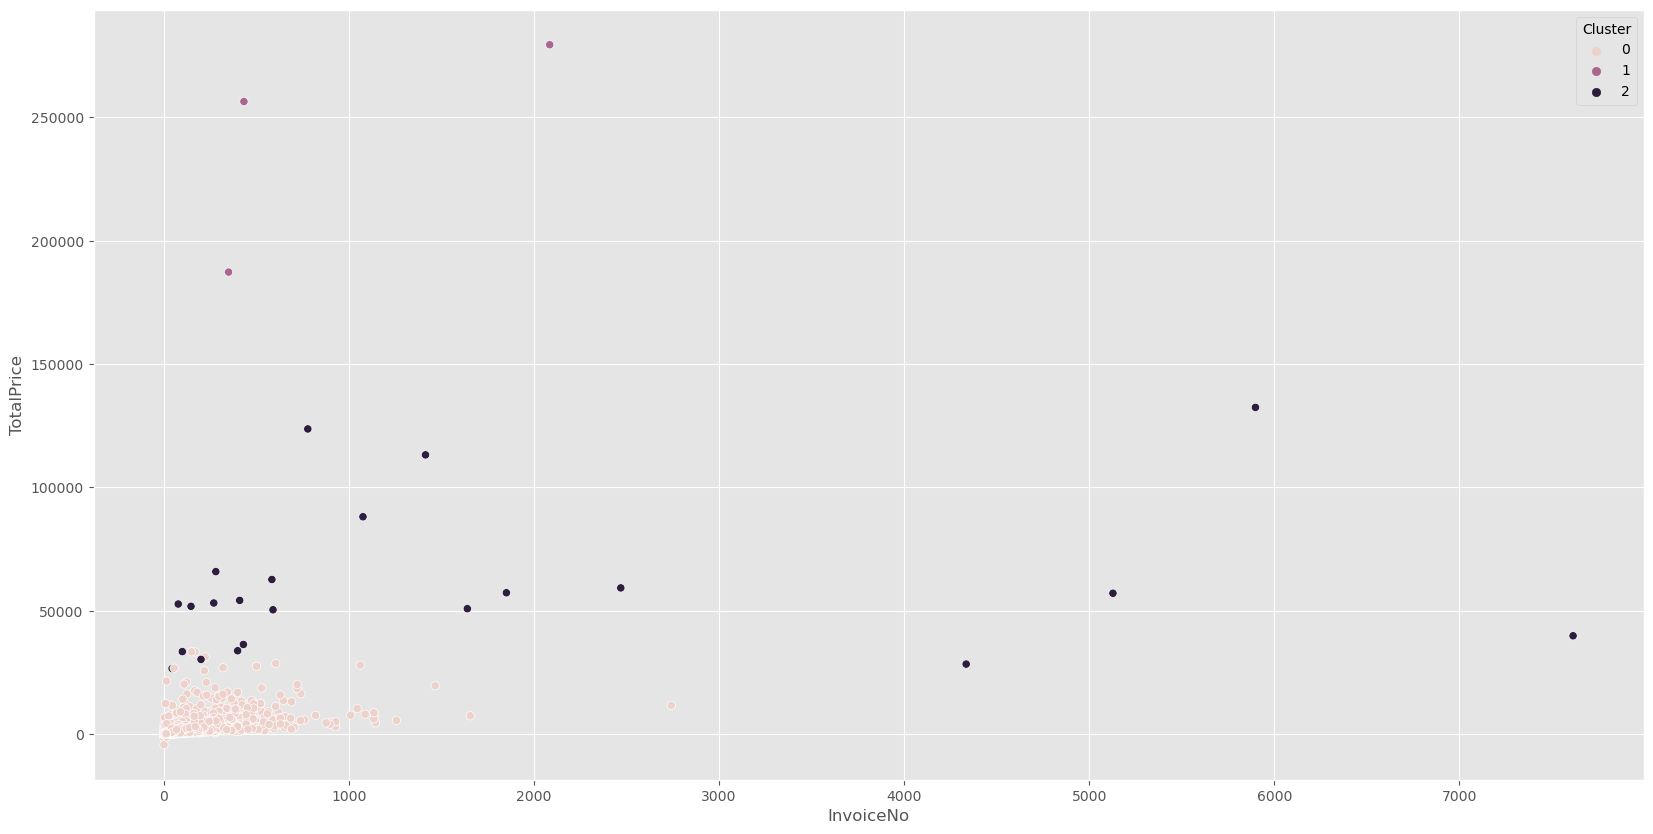

In [590]:
plt.figure(figsize=(20,10))
sns.scatterplot(x = 'InvoiceNo', y= 'TotalPrice', hue = 'Cluster', data = df_customer)
plt.show()